In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time
import joblib
import os
import tempfile
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [8]:
df = pd.read_csv("../data/noalpha.csv")
print(df.shape)
df.head()

(5762, 17)


,Unnamed: 0,ID,RAdeg,DEdeg,e_RAdeg,e_DEdeg,RApeak,DEpeak,Sint,e_Sint,Speak,e_Speak,rmspeak,e_rmspeak,thetamaj,thetamin,PA
0,0,J022143.11-041344.6,35.42963,-4.22905,2.59,2.65,35.43002,-4.22940,469.39263,0.01424,301.11002,0.00914,0.02774,0.02761,24.06,14.99,136.56
1,1,J022255.74-051817.5,35.73225,-5.30485,2.29,2.07,35.73219,-5.30480,269.69099,0.01880,232.57525,0.01621,0.02984,0.02973,23.57,21.31,95.65
2,2,J022632.54-051328.8,36.63557,-5.22467,2.13,1.98,36.63563,-5.22469,71.48008,0.00953,68.15745,0.00909,0.01850,0.01847,20.27,17.55,60.05
3,3,J022915.86-044216.7,37.31609,-4.70464,3.94,3.38,37.31561,-4.70498,272.04369,0.04092,153.31504,0.02306,0.05453,0.05453,32.70,18.35,53.51
4,4,J021640.74-044404.4,34.16974,-4.73456,2.06,2.08,34.16980,-4.73445,60.58129,0.00945,52.00014,0.00811,0.02091,0.02088,17.02,16.45,34.36


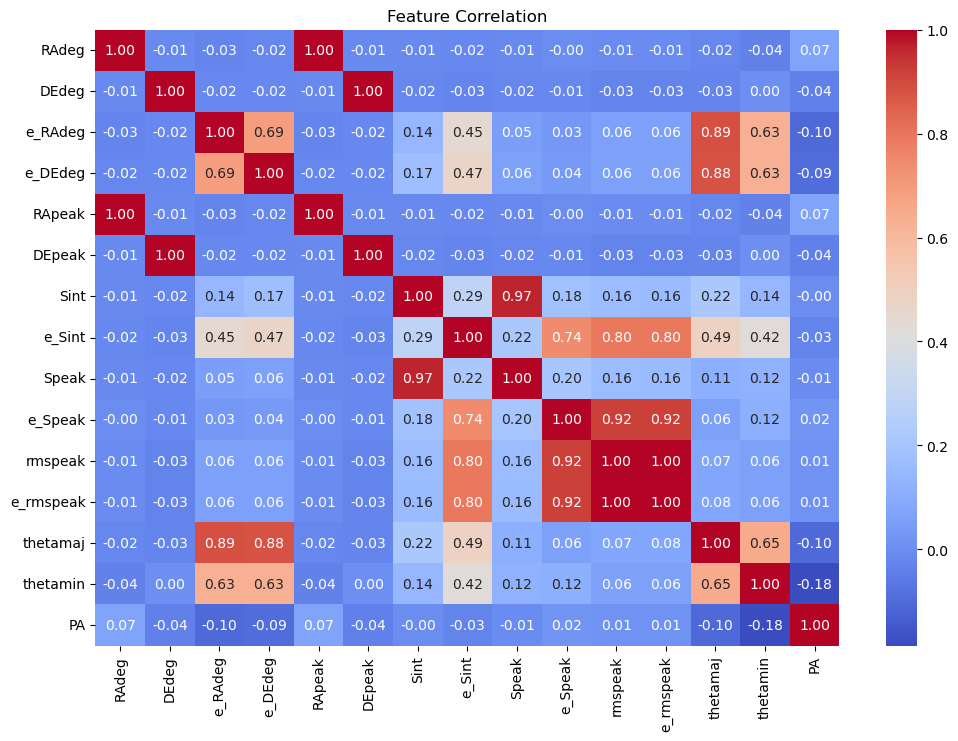

In [9]:
df.dropna(inplace=True)
df = df.drop(columns=["ID","Unnamed: 0"])


plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [10]:
X = df.drop(columns=["thetamaj", "thetamin"])
y = df[["thetamaj", "thetamin"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [16]:
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

In [19]:
def evaluate_model(model, X_test, y_test, model_name):
    # Inference time
    start = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start

    # Metrics
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    # Model size
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pkl") as temp_model_file:
        joblib.dump(model, temp_model_file.name)
        model_size_kb = os.path.getsize(temp_model_file.name) / 1024
        os.unlink(temp_model_file.name)  # Delete after measuring

    # Parameters (only available for some models)
    try:
        if hasattr(model.estimator_, 'get_params'):
            n_params = len(model.estimator_.get_params())
        elif hasattr(model, 'get_params'):
            n_params = len(model.get_params())
        else:
            n_params = "N/A"
    except:
        n_params = "N/A"

    # Print report
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Inference Time: {inference_time:.4f} sec")
    print(f"Model Size: {model_size_kb:.2f} KB")
    print(f"Total Parameters: {n_params}")

    print(f"MSE       - thetamaj: {mse[0]:.4f}, thetamin: {mse[1]:.4f}")
    print(f"RMSE      - thetamaj: {rmse[0]:.4f}, thetamin: {rmse[1]:.4f}")
    print(f"MAE       - thetamaj: {mae[0]:.4f}, thetamin: {mae[1]:.4f}")
    print(f"R² Score  - thetamaj: {r2[0]:.4f}, thetamin: {r2[1]:.4f}")


In [20]:
evaluate_model(lr, X_test_scaled, y_test, "Linear Regression")
evaluate_model(rf, X_test_scaled, y_test, "Random Forest")


--- Linear Regression Evaluation ---
Inference Time: 0.0023 sec
Model Size: 1.26 KB
Total Parameters: N/A
MSE       - thetamaj: 5.0427, thetamin: 7.8931
RMSE      - thetamaj: 2.2456, thetamin: 2.8095
MAE       - thetamaj: 1.2376, thetamin: 1.6406
R² Score  - thetamaj: 0.9226, thetamin: 0.3806

--- Random Forest Evaluation ---
Inference Time: 0.1243 sec
Model Size: 81057.39 KB
Total Parameters: N/A
MSE       - thetamaj: 4.3555, thetamin: 1.6400
RMSE      - thetamaj: 2.0870, thetamin: 1.2806
MAE       - thetamaj: 0.7888, thetamin: 0.6800
R² Score  - thetamaj: 0.9331, thetamin: 0.8713
